In [1]:
import torch 
import numpy as np
from torchvision import models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
from torch.nn.modules.activation import Sigmoid
from torch.nn.modules.pooling import AdaptiveAvgPool2d
from torchsummary import summary
from tqdm import tqdm
from torch.nn.modules.activation import Sigmoid
from torch.nn.modules.pooling import AdaptiveAvgPool2d

import transform
import mydataset

C:\Users\Administrator\anaconda3\envs\box\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model = models.resnet50(pretrained=True)


C:\Users\Administrator\anaconda3\envs\box\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Administrator/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [01:04<00:00, 1.59MB/s]


In [19]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [10]:
final_predictor = nn.Sequential(
    nn.Linear(2048, 8),
    
)

model.fc = final_predictor

In [11]:
model = model.to(device)

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
def get_essentials():  
    loss_fun = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    return loss_fun, optimizer

In [14]:
def train_batch(data, model, loss_fun, optimizer):
    model.train()
    img = data['image']
    true_points = data ['keypoints']
    true_points = true_points.type(torch.FloatTensor)
    true_points=true_points.flatten()
    #print(true_points.shape)
    img = img.type(torch.FloatTensor)
    print(img.shape)
    pred_points = model(img)
    pred_points=pred_points.flatten()
    #print(pred_points.shape)
    loss_val = loss_fun(pred_points, true_points)
    loss_val.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss_val.item()

In [15]:
@torch.no_grad()
def val_batch(data, model, loss_fun, optimizer):
    model.eval()
    img = data['image']
    true_points = data ['keypoints']
    true_points = true_points.type(torch.FloatTensor)
    true_points=true_points.flatten()
    img = img.type(torch.FloatTensor)

    pred_points = model(img)
    pred_points=pred_points.flatten()
  
    loss_val = loss_fun(pred_points, true_points)
    return loss_val.item()

In [16]:
epochs = 20
loss_fun, optimizer = get_essentials()

In [17]:
DIR = r'C:\\Users\Administrator\Desktop\AIOR_Group\\Project1\src\box_dataset'
triandataobj = mydataset.MyDataset(img_dir = DIR, annotation_file = 'dataset.json', transform = transform.data_transform, datatype = 'train')
testdataobj = mydataset.MyDataset(img_dir = DIR, annotation_file = 'dataset.json', transform = transform.data_transform, datatype = 'test')

train_dataloader = DataLoader(triandataobj, batch_size=20, shuffle=True)
test_dataloader = DataLoader(testdataobj, batch_size=20, shuffle=True)

In [18]:
train_epoch, val_epoch = [], []

for epoch in tqdm(range(epochs)):
    train_batch_losses, val_batch_losses = [], []
    for data in train_dataloader:
        train_batch_loss = train_batch(data, model, loss_fun, optimizer)
        train_batch_losses.append(train_batch_loss)

    for data in test_dataloader:
        val_batch_loss = val_batch(data, model, loss_fun, optimizer)
        val_batch_losses.append(val_batch_loss)
    train_epoch.append(np.mean(train_batch_losses))
    val_epoch.append(np.mean(val_batch_losses))

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

  5%|████                                                                              | 1/20 [01:42<32:21, 102.20s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 10%|████████▎                                                                          | 2/20 [03:15<29:09, 97.17s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 15%|████████████▍                                                                      | 3/20 [04:45<26:30, 93.53s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 20%|████████████████▌                                                                  | 4/20 [06:13<24:23, 91.47s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 25%|████████████████████▊                                                              | 5/20 [07:41<22:33, 90.27s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 30%|████████████████████████▉                                                          | 6/20 [09:10<20:56, 89.74s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 35%|█████████████████████████████                                                      | 7/20 [10:38<19:19, 89.16s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 40%|█████████████████████████████████▏                                                 | 8/20 [12:06<17:45, 88.82s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 45%|█████████████████████████████████████▎                                             | 9/20 [13:34<16:15, 88.68s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 50%|█████████████████████████████████████████                                         | 10/20 [15:02<14:44, 88.48s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 55%|█████████████████████████████████████████████                                     | 11/20 [16:30<13:15, 88.38s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 60%|█████████████████████████████████████████████████▏                                | 12/20 [17:58<11:46, 88.31s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 65%|█████████████████████████████████████████████████████▎                            | 13/20 [19:27<10:18, 88.33s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [20:55<08:50, 88.35s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [22:23<07:21, 88.25s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [23:52<05:53, 88.34s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [25:20<04:24, 88.32s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [26:48<02:56, 88.26s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [28:17<01:28, 88.28s/it]

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'nump

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [29:45<00:00, 89.26s/it]


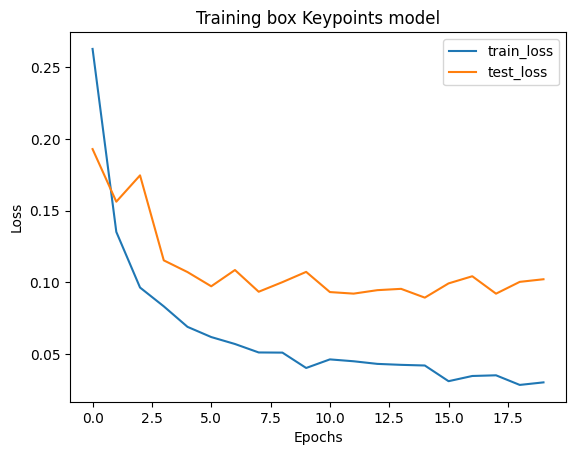

In [20]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_epoch, label="train_loss")
plt.plot(range(epochs), val_epoch, label="test_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training box Keypoints model")
plt.show()

In [28]:
idx = 15
img = testdataobj[idx]['image']
true_points = testdataobj[idx]['keypoints']
true_points = true_points.type(torch.FloatTensor)
img = img.type(torch.FloatTensor)
print(type(img))
print(img.shape)
pred_points = model(img[None])
#pred_points = pred_points.flatten()
#true_points = true_points.flatten()
print(pred_points)
print(true_points)

<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(3, 256, 256)
<class 'torch.Tensor'>
torch.Size([3, 256, 256])
tensor([[0.5297, 0.4820, 0.5205, 0.4771, 0.5005, 0.5538, 0.4839, 0.4432]],
       grad_fn=<AddmmBackward0>)
tensor([[0.6130, 0.6023],
        [0.3787, 0.5923],
        [0.3870, 0.3977],
        [0.6213, 0.4077]])


[[156.92274  154.20026 ]
 [ 96.94042  151.62799 ]
 [ 99.077255 101.79974 ]
 [159.05959  104.37201 ]]
tensor([[[0.5297, 0.4820],
         [0.5205, 0.4771],
         [0.5005, 0.5538],
         [0.4839, 0.4432]]])
tensor([[[135.5914, 123.3957],
         [133.2414, 122.1449],
         [128.1281, 141.7632],
         [123.8667, 113.4548]]])


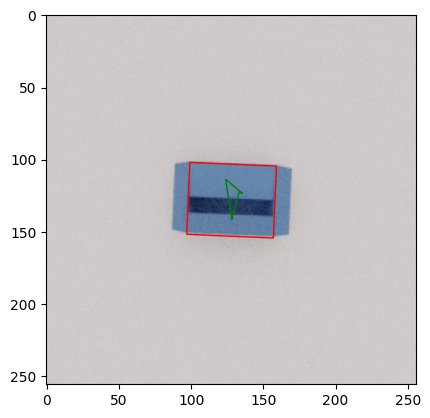

In [29]:
from matplotlib.patches import Polygon
import matplotlib.patches as patches


fig, ax = plt.subplots()

imag = img.squeeze().numpy()     
imag = imag.transpose((1, 2, 0))                
ax.imshow(imag)
corners = np.array(true_points)

corners = np.multiply(corners,256)
print (corners)

corners=corners.squeeze()
P1 = patches.Polygon(corners, linewidth=1, edgecolor='r', facecolor='none')

pred_points=torch.reshape(pred_points,(1,4,2))
corners = pred_points.detach()
corners.shape

print (corners)

corners = np.multiply(corners,256)
print (corners)
corners=corners.squeeze()
P2 = patches.Polygon(corners, linewidth=1, edgecolor='g', facecolor='none')


ax.add_patch(P1)
ax.add_patch(P2)
plt.show()
